In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
customized_path = "/content/drive/Shareddrives/Urban Computing Project/"
sys.path.append(customized_path)

In [3]:
# pip install sktime

     |████████████████████████████████| 6.2 MB 5.7 MB/s 
     |████████████████████████████████| 3.3 MB 47.0 MB/s 
     |████████████████████████████████| 9.8 MB 20.0 MB/s 
     |████████████████████████████████| 14.9 MB 11.9 MB/s 
     |████████████████████████████████| 26.3 MB 34.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: pip's dependency resolver does not currently take into account

In [3]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 8.5 MB/s 


In [4]:
import numpy as np
import pandas as pd
%matplotlib inline

In [5]:
df = pd.read_csv('/content/drive/Shareddrives/Urban Computing Project/datasets/aggregated_taxi_and_bus_data_with_lid.csv')

In [6]:
df.head()

,timekey,locationID,BusesThatReachedStop,BusesThatReachedLate,OnTimeBuses,AvgLeadTime,AvgLateTime,TaxiTripsBookedAtTimeSlot,TaxiAvgFareAtTimeSlot,TaxiAvgPassAtTimeSlot,TaxiTotalFareAtTimeSlot,TaxiAvgTripDistAtTimeSlot,TaxiAvgTripTimeAtTimeSlot,TaxiTripsBookedAtTMinusFiveSlot,TaxiAvgFareAtTMinusFiveSlot,TaxiAvgPassAtTMinusFiveSlot,TaxiTotalFareAtTMinusFiveSlot,TaxiAvgTripDistAtTMinusFiveSlot,TaxiAvgTripTimeAtTMinusFiveSlot,TaxiTripsBookedAtTMinusTenSlot,TaxiAvgFareAtTMinusTenSlot,TaxiAvgPassAtTMinusTenSlot,TaxiTotalFareAtTMinusTenSlot,TaxiAvgTripDistAtTMinusTenlot,TaxiAvgTripTimeAtTMinusTenSlot,TaxiTripsBookedAtTMinusFifteenSlot,TaxiAvgFareAtTMinusFifteenSlot,TaxiAvgPassAtTMinusFifteenSlot,TaxiTotalFareAtTMinusFifteenSlot,TaxiAvgTripDistAtTMinusFifteenSlot,TaxiAvgTripTimeAtTMinusFifteenSlot,TaxiTripsBookedAtTMinusTwentySlot,TaxiAvgFareAtTMinusTwentySlot,TaxiAvgPassAtTMinusTwentySlot,TaxiTotalFareAtTMinusTwentySlot,TaxiAvgTripDistAtTMinusTwentySlot,TaxiAvgTripTimeAtTMinusTwentySlot
0,2017-10-14 08:10:00 UTC,42,1,0,1,1.0,0.0,2,0.000000e+00,1.500000,0.0,0,14.000000,2,0.000000e+00,1.50,0.000000e+00,0,9.00,1,0.0,1.0,0.0,0,8.0,2,0.000000e+00,2.0,0.0,0,8.000000,2,0.000000e+00,2.000000,-1.500000e-08,0,17.5
1,2017-10-15 21:50:00 UTC,125,1,0,1,19.0,0.0,6,-1.400000e-08,1.333333,0.0,0,14.833333,4,-1.000000e-08,1.75,-1.000000e-08,0,14.25,1,0.0,2.0,0.0,0,4.0,6,-7.000000e-09,1.5,0.0,0,12.833333,5,0.000000e+00,1.000000,0.000000e+00,0,6.4
2,2017-10-20 19:10:00 UTC,232,1,0,1,21.0,0.0,1,0.000000e+00,1.000000,0.0,0,8.000000,2,-2.100000e-08,2.50,0.000000e+00,0,20.50,1,0.0,1.0,0.0,0,8.0,4,-2.600000e-08,1.0,0.0,0,35.500000,3,-1.800000e-08,2.333333,0.000000e+00,0,46.0
3,2017-10-25 06:50:00 UTC,209,1,0,1,1.0,0.0,1,-3.700000e-08,1.000000,0.0,0,22.000000,4,-2.100000e-08,1.50,0.000000e+00,0,13.50,1,0.0,1.0,0.0,0,79.0,1,0.000000e+00,1.0,0.0,0,17.000000,3,-3.400000e-08,1.000000,-1.400000e-08,0,25.0
4,2017-10-25 19:30:00 UTC,232,1,0,1,2.0,0.0,3,-8.000000e-09,1.000000,0.0,0,13.000000,2,0.000000e+00,3.00,0.000000e+00,0,16.50,1,0.0,1.0,0.0,0,22.0,2,0.000000e+00,1.5,0.0,0,7.000000,5,0.000000e+00,1.800000,-7.000000e-09,0,10.8


In [7]:
df['locationID'].value_counts()

164    15786
107    12140
41     10054
143    10017
238    10012
       ...  
194        1
189        1
135        1
130        1
215        1
Name: locationID, Length: 98, dtype: int64

In [8]:
df['timekey'] = pd.to_datetime(df['timekey'], errors = 'coerce')
df['date'] = df['timekey'].dt.date
df['day'] = df['timekey'].dt.dayofweek
df['hour'] = df['timekey'].dt.hour

In [9]:
df.head()

,timekey,locationID,BusesThatReachedStop,BusesThatReachedLate,OnTimeBuses,AvgLeadTime,AvgLateTime,TaxiTripsBookedAtTimeSlot,TaxiAvgFareAtTimeSlot,TaxiAvgPassAtTimeSlot,TaxiTotalFareAtTimeSlot,TaxiAvgTripDistAtTimeSlot,TaxiAvgTripTimeAtTimeSlot,TaxiTripsBookedAtTMinusFiveSlot,TaxiAvgFareAtTMinusFiveSlot,TaxiAvgPassAtTMinusFiveSlot,TaxiTotalFareAtTMinusFiveSlot,TaxiAvgTripDistAtTMinusFiveSlot,TaxiAvgTripTimeAtTMinusFiveSlot,TaxiTripsBookedAtTMinusTenSlot,TaxiAvgFareAtTMinusTenSlot,TaxiAvgPassAtTMinusTenSlot,TaxiTotalFareAtTMinusTenSlot,TaxiAvgTripDistAtTMinusTenlot,TaxiAvgTripTimeAtTMinusTenSlot,TaxiTripsBookedAtTMinusFifteenSlot,TaxiAvgFareAtTMinusFifteenSlot,TaxiAvgPassAtTMinusFifteenSlot,TaxiTotalFareAtTMinusFifteenSlot,TaxiAvgTripDistAtTMinusFifteenSlot,TaxiAvgTripTimeAtTMinusFifteenSlot,TaxiTripsBookedAtTMinusTwentySlot,TaxiAvgFareAtTMinusTwentySlot,TaxiAvgPassAtTMinusTwentySlot,TaxiTotalFareAtTMinusTwentySlot,TaxiAvgTripDistAtTMinusTwentySlot,TaxiAvgTripTimeAtTMinusTwentySlot,date,day,hour
0,2017-10-14 08:10:00+00:00,42,1,0,1,1.0,0.0,2,0.000000e+00,1.500000,0.0,0,14.000000,2,0.000000e+00,1.50,0.000000e+00,0,9.00,1,0.0,1.0,0.0,0,8.0,2,0.000000e+00,2.0,0.0,0,8.000000,2,0.000000e+00,2.000000,-1.500000e-08,0,17.5,2017-10-14,5,8
1,2017-10-15 21:50:00+00:00,125,1,0,1,19.0,0.0,6,-1.400000e-08,1.333333,0.0,0,14.833333,4,-1.000000e-08,1.75,-1.000000e-08,0,14.25,1,0.0,2.0,0.0,0,4.0,6,-7.000000e-09,1.5,0.0,0,12.833333,5,0.000000e+00,1.000000,0.000000e+00,0,6.4,2017-10-15,6,21
2,2017-10-20 19:10:00+00:00,232,1,0,1,21.0,0.0,1,0.000000e+00,1.000000,0.0,0,8.000000,2,-2.100000e-08,2.50,0.000000e+00,0,20.50,1,0.0,1.0,0.0,0,8.0,4,-2.600000e-08,1.0,0.0,0,35.500000,3,-1.800000e-08,2.333333,0.000000e+00,0,46.0,2017-10-20,4,19
3,2017-10-25 06:50:00+00:00,209,1,0,1,1.0,0.0,1,-3.700000e-08,1.000000,0.0,0,22.000000,4,-2.100000e-08,1.50,0.000000e+00,0,13.50,1,0.0,1.0,0.0,0,79.0,1,0.000000e+00,1.0,0.0,0,17.000000,3,-3.400000e-08,1.000000,-1.400000e-08,0,25.0,2017-10-25,2,6
4,2017-10-25 19:30:00+00:00,232,1,0,1,2.0,0.0,3,-8.000000e-09,1.000000,0.0,0,13.000000,2,0.000000e+00,3.00,0.000000e+00,0,16.50,1,0.0,1.0,0.0,0,22.0,2,0.000000e+00,1.5,0.0,0,7.000000,5,0.000000e+00,1.800000,-7.000000e-09,0,10.8,2017-10-25,2,19


In [10]:
df1 = df[df['locationID'] == 164]

In [11]:
df2 = df1.filter(['AvgLateTime','BusesThatReachedLate', 'day', 'date', 'hour', 'WeekendOrNot'], axis =1)

In [12]:
df2['cumulative_late_time'] = df2['BusesThatReachedLate'] * df2['AvgLateTime']

In [13]:
df3 = df2[df2['hour'] == 9]

In [14]:
df3['date'] = pd.to_datetime(df3['date'], errors = 'coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df3 = df3.sort_values(by='date')

In [16]:
df3 = df3[(df3['date'] > '2017-05-21') & (df3['date'] < '2017-07-01')]

In [17]:
df3 = df3.set_index(['date']).drop(['day', 'hour'], axis=1)

In [18]:
df3.head()

,AvgLateTime,BusesThatReachedLate,cumulative_late_time
date,,,
2017-06-01,3.0,1,3.0
2017-06-01,0.0,0,0.0
2017-06-01,3.0,3,9.0
2017-06-01,1.5,1,1.5
2017-06-01,6.0,2,12.0


In [19]:
df_sum = df3.groupby(['date']).sum()

In [20]:
df_sum = df_sum.drop('AvgLateTime', axis=1)

In [21]:
df_sum['avg_late_time'] = df_sum['BusesThatReachedLate'] / df_sum['cumulative_late_time']

In [22]:
df_sum = df_sum.rename(columns={'BusesThatReachedLate': "num_late", "cumulative_late_time": "total_min", "avg_late_time": "avg_min"})

# Data Visualization

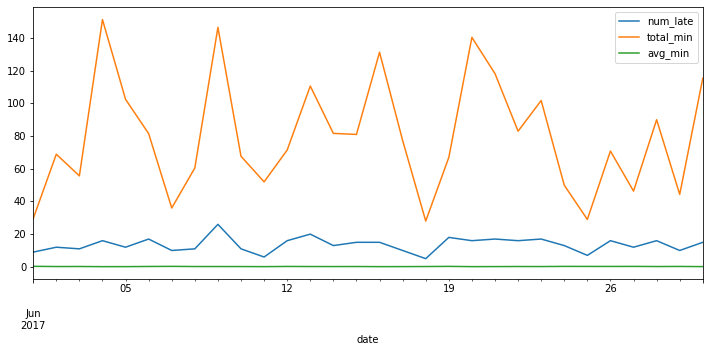

In [23]:
df_sum.plot(figsize=(12, 5))

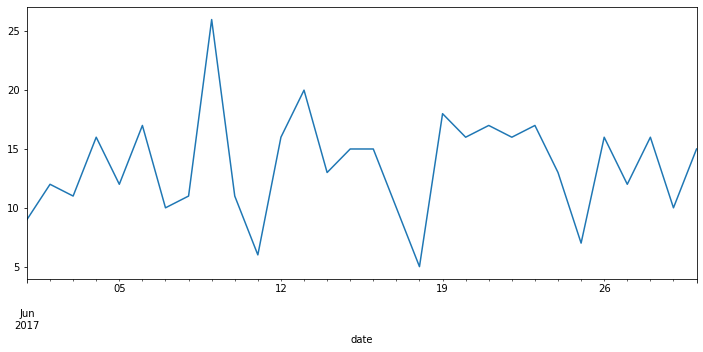

In [24]:
df_sum['num_late'].plot(figsize=(12, 5))

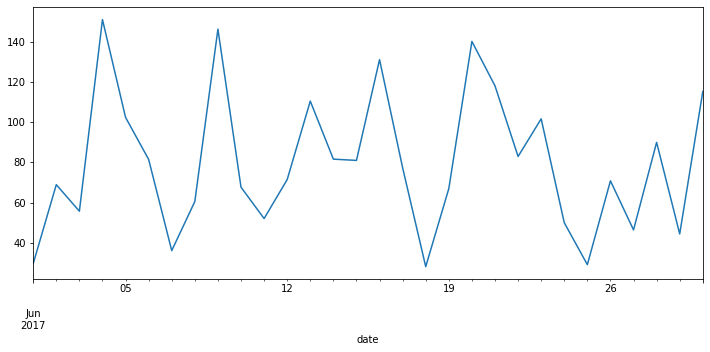

In [25]:
df_sum['total_min'].plot(figsize=(12, 5))

# Model Evaluation

In [26]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error,mean_absolute_error

### Augmented Dickey-Fuller Test

In [27]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [28]:
adf_test(df_sum['total_min'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.001697
p-value                  0.000022
# lags used              0.000000
# observations          29.000000
critical value (1%)     -3.679060
critical value (5%)     -2.967882
critical value (10%)    -2.623158
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [29]:
auto_arima(df_sum['total_min'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:                        SARIMAX   Log Likelihood                -148.926
Date:                Mon, 13 Dec 2021   AIC                            301.851
Time:                        22:17:29   BIC                            304.653
Sample:                             0   HQIC                           302.748
                                 - 30                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     79.6620      6.852     11.627      0.000      66.233      93.091
sigma2      1200.4957    411.459      2.918      0.004     394.051    2006.941
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.76   Prob(JB):                         0.46
Heteroskedasticity (H):               0.59   Skew:                             0.44
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
train_data = df_sum.iloc[:23]
test_data = df_sum.iloc[23:]

# ARMA

## Number of late buses

In [ ]:
model = AutoReg(train_data['num_late'], lags = 4)
ARfit1 = model.fit()

In [ ]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = ARfit1.predict(start=start, end=end, dynamic=False).rename('AR(4) Predictions')

In [ ]:
predictions1

2017-06-24    12.356569
2017-06-25    12.545996
2017-06-26    15.044433
2017-06-27    14.473591
2017-06-28    13.763416
2017-06-29    14.127294
2017-06-30    14.173861
Freq: D, Name: AR(4) Predictions, dtype: float64

In [ ]:
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]}, expected={test_data['num_late'][i]}")

predicted=12.356568629101924, expected=13
predicted=12.545996397268828, expected=7
predicted=15.04443332816146, expected=16
predicted=14.473590732877794, expected=12
predicted=13.763415526738838, expected=16
predicted=14.127294193415233, expected=10
predicted=14.173861278981013, expected=15


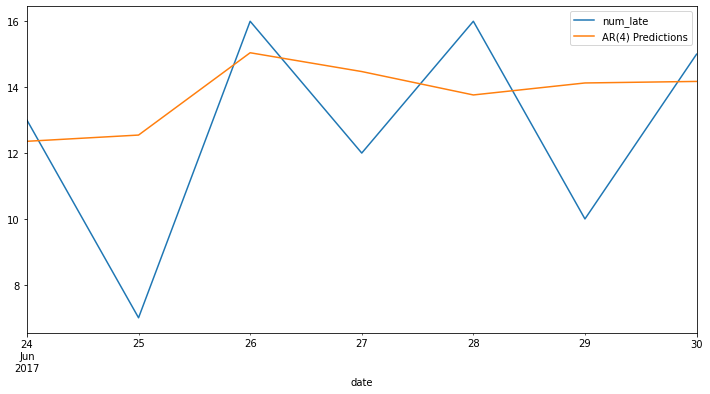

In [ ]:
test_data['num_late'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

In [ ]:
test_data.describe()

,num_late,total_min,avg_min
count,7.000000,7.000000,7.000000
mean,12.714286,63.698980,0.217116
std,3.352327,30.247199,0.047447
min,7.000000,29.000000,0.129964
25%,11.000000,45.333333,0.201638
50%,13.000000,49.933333,0.225852
75%,15.500000,80.438095,0.250186
max,16.000000,115.416667,0.260347


In [ ]:
mean_squared_error(test_data['num_late'],predictions1)

8.703315913868712

In [ ]:
np.sqrt(mean_squared_error(test_data['num_late'],predictions1))

2.9501382872449744

In [ ]:
mean_absolute_error(test_data['num_late'],predictions1)

2.4012289372255173

## Total late time

In [ ]:
model2 = AutoReg(train_data['total_min'], lags = 0, seasonal=False)
ARfit2 = model2.fit()

In [ ]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions2 = ARfit2.predict(start=start, end=end, dynamic=False).rename('AR(0) Predictions')

In [ ]:
for i in range(len(predictions2)):
    print(f"predicted={predictions2[i]}, expected={test_data['total_min'][i]}")

predicted=84.52035886818496, expected=49.93333333333334
predicted=84.52035886818496, expected=29.000000000000004
predicted=84.52035886818496, expected=70.84285714285716
predicted=84.52035886818496, expected=46.33333333333333
predicted=84.52035886818496, expected=90.03333333333333
predicted=84.52035886818496, expected=44.333333333333336
predicted=84.52035886818496, expected=115.41666666666667


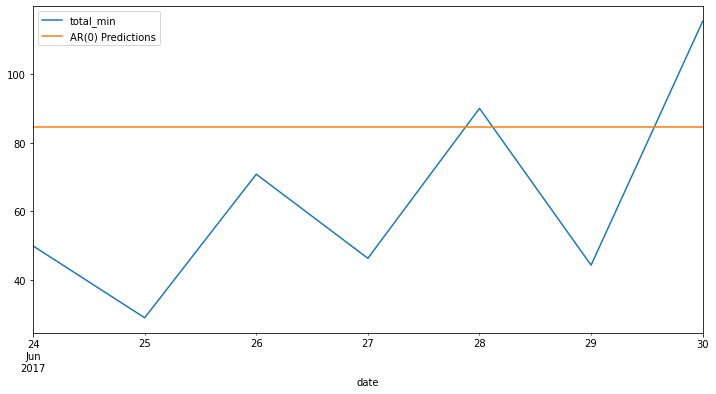

In [ ]:
test_data['total_min'].plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

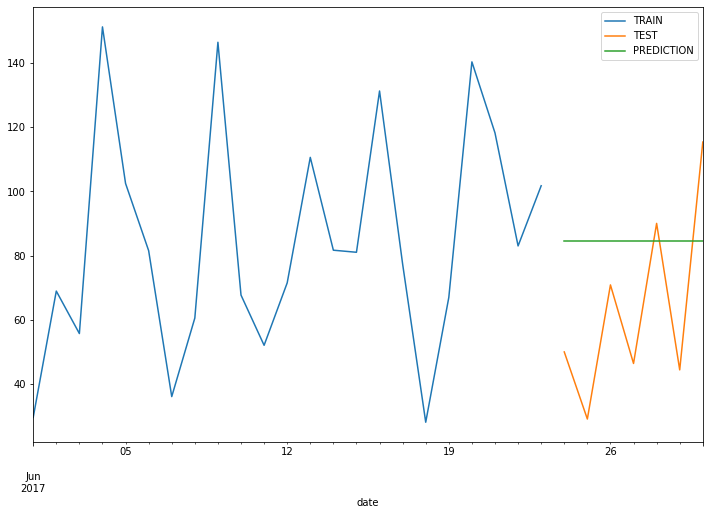

In [ ]:
train_data['total_min'].plot(legend=True,label='TRAIN')
test_data['total_min'].plot(legend=True,label='TEST',figsize=(12,8))
predictions2.plot(legend=True,label='PREDICTION');

In [ ]:
np.sqrt(mean_squared_error(test_data['total_min'],predictions2))

34.89590090789828

In [ ]:
mean_absolute_error(test_data['num_late'],predictions2)

71.80607315389925

# SARIMAX

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

import warnings
warnings.filterwarnings("ignore")

In [32]:
model = SARIMAX(train_data['total_min'])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              total_min   No. Observations:                   23
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -121.213
Date:                Mon, 13 Dec 2021   AIC                            246.425
Time:                        22:19:30   BIC                            248.696
Sample:                    06-01-2017   HQIC                           246.996
                         - 06-23-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8564      0.144      5.959      0.000       0.575       1.138
sigma2      2089.8961    776.533      2.691      0.007     567.920    3611.872
===================================================================================
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.28   Prob(JB):                         0.59
Heteroskedasticity (H):               1.06   Skew:                             0.40
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0) Predictions')

In [35]:
predictions

2017-06-24    87.148905
2017-06-25    74.630838
2017-06-26    63.910866
2017-06-27    54.730710
2017-06-28    46.869192
2017-06-29    40.136902
2017-06-30    34.371638
Freq: D, Name: SARIMA(1,0,0) Predictions, dtype: float64

In [37]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test_data['total_min'][i]}")

predicted=87.14890468478657, expected=49.93333333333334
predicted=74.63083774410103, expected=29.000000000000004
predicted=63.9108656905316, expected=70.84285714285716
predicted=54.73071021015069, expected=46.33333333333333
predicted=46.869192080921366, expected=90.03333333333333
predicted=40.13690225987393, expected=44.333333333333336
predicted=34.37163841521468, expected=115.41666666666667


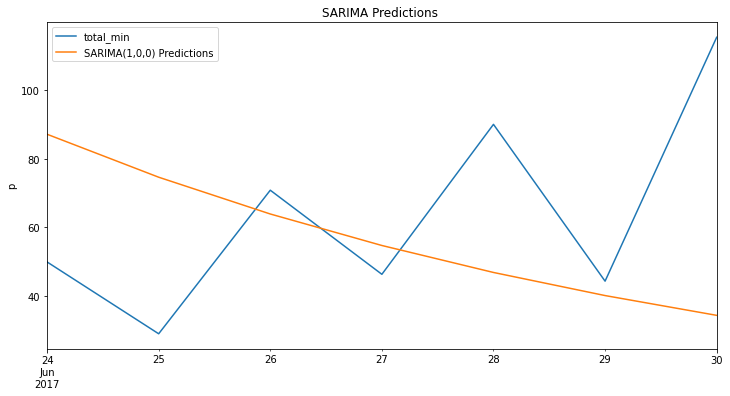

In [44]:
title = 'SARIMA Predictions '
ylabel='p'
xlabel=''

ax = test_data['total_min'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [43]:
from statsmodels.tools.eval_measures import rmse, meanabs

error_arima = rmse(test_data['total_min'], predictions)
error_arima_mae = meanabs(test_data['total_min'], predictions)

In [41]:
test_data.describe()

,num_late,total_min,avg_min
count,7.000000,7.000000,7.000000
mean,12.714286,63.698980,0.217116
std,3.352327,30.247199,0.047447
min,7.000000,29.000000,0.129964
25%,11.000000,45.333333,0.201638
50%,13.000000,49.933333,0.225852
75%,15.500000,80.438095,0.250186
max,16.000000,115.416667,0.260347


#Holt-Winters

In [45]:
fitted_model = ExponentialSmoothing(train_data['total_min']).fit()

In [48]:
test_predictions = fitted_model.forecast(7).rename('HW Forecast')

In [49]:
test_predictions

2017-06-24    84.432769
2017-06-25    84.432769
2017-06-26    84.432769
2017-06-27    84.432769
2017-06-28    84.432769
2017-06-29    84.432769
2017-06-30    84.432769
Freq: D, Name: HW Forecast, dtype: float64

In [50]:
error_holt = rmse(test_data['total_min'], test_predictions)
error_holt_mae = meanabs(test_data['total_min'], test_predictions)

In [51]:
d = {'Model':['ARIMA', 'Holt-Winters'],'RMSE':[error_arima, error_holt], 'MAE':[error_arima_mae, error_holt_mae]}

In [52]:
df_eval = pd.DataFrame(data=d)

In [53]:
df_eval.set_index(['Model'])

,RMSE,MAE
Model,,
ARIMA,41.463909,32.368768
Holt-Winters,34.843709,31.186493
